# Notebook overview

The objective of this notebook is to offer a first approximation at Image Classification problems.

For this, we will be using a very popular library `PyTorch` and a DataSet of fruits and vegetables.



---


❗ **Before running the notebook in colab, go to the top menu: `Runtime` > `Change runtime type` > `Hardware accelerator` and select the option "T4 GPU" to ensure faster execution.**

In [1]:
!pip install -q eccd_datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 MB 12.3 MB/s eta 0:00:00


In [2]:
import io
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import requests
import torch
import torchvision.transforms.v2 as transforms

from eccd_datasets import load_images
from PIL import Image
from torchvision import models

torch.manual_seed(42)

In [3]:
# Download the original lables used when training a resnet

resnet_labels = {
    int(index): label
    for index, (id, label) in requests.get(
        "https://files.fast.ai/models/imagenet_class_index.json"
    )
    .json()
    .items()
}
resnet_labels[10]

'brambling'

# Exploring the dataset

First, we invite you to go to the dataset folder and explore the content and structure of the project.

The dataset used in this notebook consists on a subset from the dataset located [here](https://github.com/marcusklasson/GroceryStoreDataset)

Once that is done, we can start looking at what is included in the dataset

In [4]:
df_images = load_images()
df_images.head()

,dataset,coarse_cat,finegrained_cat,image_data
0,train,Apple,Golden-Delicious,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
1,train,Apple,Golden-Delicious,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
2,train,Apple,Golden-Delicious,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
3,train,Apple,Golden-Delicious,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
4,train,Apple,Golden-Delicious,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...


### Looking at the images

We can use the `PIL` library to look at the images

In [5]:
def load_image_data(image_data):
    return Image.open(io.BytesIO(image_data))

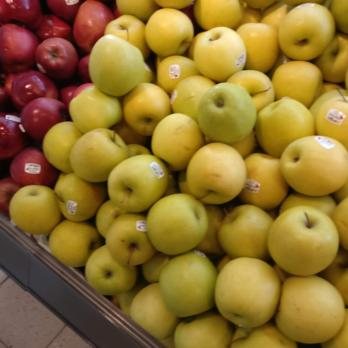

In [15]:
image = load_image_data(df_images.iloc[0]["image_data"])
image

### Images as matrices

We can also look look at the matrix representation of each image using numpy

In [7]:
I = np.array(image)
print("Image shape", I.shape)
print(f"Image range in each coordinate: [{I.min()}, {I.max()}]")

Image shape (348, 348, 3)
Image range in each coordinate: [0, 255]


And we can modify the image manually by changing the values of the matrix

In [8]:
new_I = I.copy()
new_I[:, :, 0] = 0 # Killing the red channel

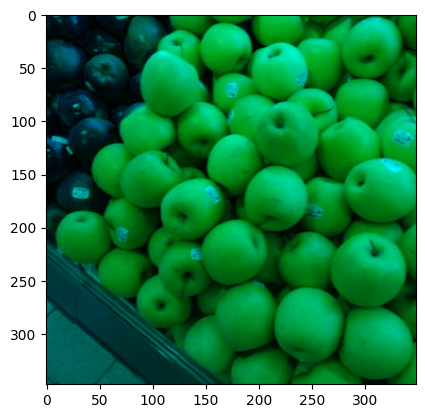

In [9]:
plt.imshow(new_I.astype(int))

# PyTorch Transformations

The same way we normalize tabular data with Standard and MinMax scalers, we need to normalize image data.

We will proceed to explore some of the most used transformations

## Resizing

In [10]:
resize_image = transforms.Resize((100, 100))

In [11]:
resized_image = resize_image(image)

Text(0.5, 1.0, 'New shape: (100, 100, 3)')

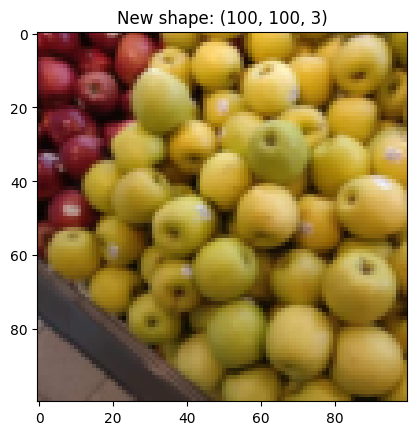

In [12]:
plt.imshow(resized_image)
plt.title(f"New shape: {np.array(resized_image).shape}")

## Center Crop

Implement a transformation for croping and centering (hint: there is a transformation that does that)

In [13]:
type(image)

PIL.JpegImagePlugin.JpegImageFile

In [16]:
from torchvision.transforms import CenterCrop

def center_crop_transformation(image, size: int) -> np.array:
    """
    This function uses a pytorch transformation to
    center and crop the image
    """
    # Write your code here

    # My code

    # Definir la transformación de recorte centrado
    center_crop = CenterCrop(size)
    # Aplicar la transformación
    cropped_image = center_crop(image)
    # Convertir la imagen recortada en un array de numpy
    return np.array(cropped_image)


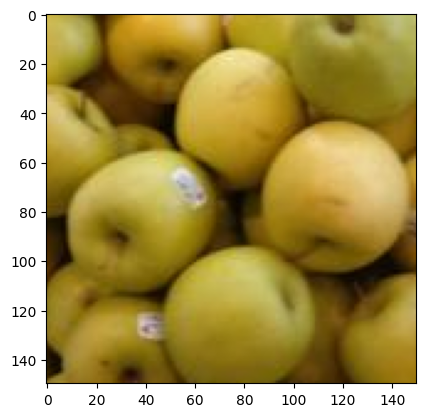

In [17]:
answer_center_crop = center_crop_transformation(image, 150)
plt.imshow(answer_center_crop)

In [18]:
assert np.array(answer_center_crop).shape == (150, 150, 3)

## RandomResizedCrop

In [ ]:
print("Image original size: ", np.array(image).shape)
fig, ax = plt.subplots(1, 6, figsize=(20, 4))
for i, size in enumerate([50, 100, 150, 200, 300, 500]):

    transformation = transforms.RandomResizedCrop(size)

    crp_img = transformation(image)
    ax[i].imshow(crp_img)
    ax[i].set_title(np.array(crp_img).shape)

## Random Horizontal Flip

In [ ]:
transformation = transforms.RandomHorizontalFlip()

maybe_flipped = [transformation(image) for _ in range(5)]

plt.imshow(np.hstack([np.array(img) for img in maybe_flipped]))

## Normalization

The same way we normalize columns for tabular data, here we normalize each image according to the mean and standard deviation of each colour channel.

In [ ]:
two_images = [
    load_image_data(row["image_data"]) for _, row in df_images.iloc[:2].iterrows()
]

In [ ]:
two_image_dataset = np.array([np.array(img) for img in two_images])
two_image_dataset.shape

plt.imshow(np.hstack([np.array(img) for img in two_images]))

In [ ]:
two_image_dataset.shape

In [ ]:
np.mean(two_image_dataset, axis=(0, 1, 2))

In [ ]:
transformation = transforms.Compose(
    [
        transforms.ToImage(),
        transforms.ToDtype(torch.float32, scale=True),
        transforms.Normalize(
            np.mean(two_image_dataset, axis=(0, 1, 2)),
            np.std(two_image_dataset, axis=(0, 1, 2)),
        ),
    ]
)

In [ ]:
transformed_two_image_dataset = [transformation(img) for img in two_image_dataset]

In [ ]:
transformed_two_image_dataset[0]

# Using ImageNet

Since training a large neural network requires lots of data and computing power, often we download a pre-trained neural network, which we can later fine-tune.

Here, we will download an ImageNet network.

Remember that since the network is already trained with a specific dataset, when evaluating new images, we need transform them using the same transformations used for training. In particular, that includes using the same normalizations.

In [ ]:
resnet = models.resnet18(pretrained=True)
# resnet = models.resnet34(pretrained=True)
# resnet = models.resnet50(pretrained=True)
# resnet = models.resnet101(pretrained=True)
# resnet = models.resnet152(pretrained=True)
resnet.eval()

In [ ]:
resnet

We load a maping from resnet integer labels to the actual categories

In [ ]:
def predict_using_resnet(image):
    """
    This image uses the resnet as is to
    predict an image.
    Remember to apply the correct transformations
    to the image before feeding it to the network.

    The following link might be useful: https://pytorch.org/hub/pytorch_vision_resnet/
    """

    # Write your code here


In [ ]:
img1 = (
    load_image_data(
        df_images[
            df_images["coarse_cat"] == "Apple"
        ]
        .iloc[0]
        ["image_data"]
    )
)
img1

In [ ]:
img2 = (
    load_image_data(
        df_images[
            df_images["coarse_cat"] == "Orange"
        ]
        .iloc[0]
        ["image_data"]
    )
)
img2

In [ ]:
img3 = (
    load_image_data(
        df_images[
            df_images["coarse_cat"] == "Pear"
        ]
        .iloc[0]
        ["image_data"]
    )
)
img3

In [ ]:
pred1 = predict_using_resnet(img1)

In [ ]:
assert pred1 == "lemon"

In [ ]:
pred2 = predict_using_resnet(img2)
print(pred2)

In [ ]:
pred3 = predict_using_resnet(img3)
print(pred3)